# Homework 3 - classifiers

In this homework we will use 7 algorithms to classify data.

## Dependencies

### General dependencies

In [ ]:
import copy
import os
import platform

if platform.system() == "Windows":
    os.environ["R_HOME"] = "C:\Program Files\R\R-4.3.3"

In [ ]:
import typing as t
import csv
import itertools
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from IPython.display import HTML, IFrame

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

In [ ]:
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import DecisionBoundaryDisplay

### Dataset-specific dependencies

In [ ]:
LABEL_VARIABLE = "NObeyesdad"
NUMERICAL_VARIABLES = ["Age", "Height", "Weight", "FCVC", "NCP", "CH2O", "FAF", "TUE"]
CATEGORICAL_VARIABLES_NO_LABEL = [
    "FAVC",
    "CAEC",
    "CALC",
    "SCC",
    "MTRANS",
    "Gender",
    "family_history_with_overweight",
    "SMOKE",
]
CATEGORICAL_VARIABLES = [
    *CATEGORICAL_VARIABLES_NO_LABEL,
    LABEL_VARIABLE,
]
ALL_VARIABLES_NO_LABEL = [*NUMERICAL_VARIABLES, *CATEGORICAL_VARIABLES_NO_LABEL]
ALL_VARIABLES = [*NUMERICAL_VARIABLES, *CATEGORICAL_VARIABLES]
LABEL_DICTIONARY = {
    "Age": "Age",
    "Height": "Height (cm)",
    "Weight": "Weight (kg)",
    "FCVC": " Frequency of consumption of vegetables (times per day)",
    "NCP": "Number of main meals",
    "CH2O": "Consumption of water daily (Liters)",
    "FAF": "Physical activity frequency (times per day)",
    "TUE": "Time using technology devices (hours)",
    "FAVC": "Frequent consumption of high caloric food",
    "CAEC": "Consumption of food between meals",
    "CALC": "Consumption of alcohol",
    "SCC": "Calories consumption monitoring",
    "MTRANS": "Transportation used",
    "Gender": "Gender",
    "family_history_with_overweight": "Family member suffered or suffers from overweight",
    "SMOKE": "Smoker or not",
    "NObeyesdad": "Obesity level",
}

T = t.TypeVar("T")


class Person:
    Gender: str
    Age: np.int32
    Height: np.float32
    Weight: np.float32
    family_history_with_overweight: str
    FAVC: str
    FCVC: np.float32
    NCP: np.float32
    CAEC: str
    SMOKE: str
    CH2O: np.float32
    SCC: str
    FAF: np.float32
    TUE: np.float32
    CALC: str
    MTRANS: str
    NObeyesdad: str

    def __init__(
        self,
        Gender: str,
        Age: str,
        Height: str,
        Weight: str,
        family_history_with_overweight: str,
        FAVC: str,
        FCVC: str,
        NCP: str,
        CAEC: str,
        SMOKE: str,
        CH2O: str,
        SCC: str,
        FAF: str,
        TUE: str,
        CALC: str,
        MTRANS: str,
        NObeyesdad: str,
    ):
        self.Gender = Gender
        self.Age = np.float32(Age)
        self.Height = np.float32(Height)
        self.Weight = np.float32(Weight)
        self.family_history_with_overweight = family_history_with_overweight
        self.FAVC = FAVC
        self.FCVC = np.float32(FCVC)
        self.NCP = np.float32(NCP)
        self.CAEC = CAEC
        self.SMOKE = SMOKE
        self.CH2O = np.float32(CH2O)
        self.SCC = SCC
        self.FAF = np.float32(FAF)
        self.TUE = np.float32(TUE)
        self.CALC = CALC
        self.MTRANS = MTRANS
        self.NObeyesdad = NObeyesdad

    def __str__(self):
        return vars(self)

    def __len__(self):
        return len(vars(self))

    def __repr__(self):
        return vars(self)


class DatasetManager:
    def __init__(self, path_to_csv: str):
        self.path_to_csv = path_to_csv

    def load_as_obj_list(self) -> list[Person]:
        with open(self.path_to_csv) as csv_file:
            csv_reader = csv.DictReader(csv_file)
            return [Person(**row) for row in csv_reader]

    def make_label_combinations(self, labels: t.List[str], k: int = 2):
        result: t.List[t.Tuple[str, ...]] = []

        for combination in itertools.combinations(labels, k):
            result.append(list(combination))

        return result

    def labels_to_onehot(
        self, dataframe: pd.DataFrame, labels: t.List[str]
    ) -> pd.DataFrame:
        return pd.get_dummies(dataframe[labels], drop_first=True)

In [ ]:
class PlotManager:
    def __init__(self, cols: int, samples: int) -> None:
        self.rows = samples // cols + 1
        self.cols = cols
        self.samples = samples
        self.index = 0

        fig = plt.figure()
        fig, axs = plt.subplots(rows, cols)
        plt.tight_layout(h_pad=2, w_pad=2, pad=0)

        self.fig = fig
        self.axs = axs

    def __len__(self):
        return self.samples

    def __getitem__(self, i: int):
        subplot_i = i // (self.rows - 1)
        subplot_j = i % self.cols
        subplot = (subplot_i, subplot_j)

        return self.axs[subplot]

    def __next__(self):
        subplot_i = self.index // (self.rows - 1)
        subplot_j = self.index % self.cols
        subplot = (subplot_i, subplot_j)

        self.index += 1

        return self.axs[subplot]

In [ ]:
dataset_manager = DatasetManager("data/ObesityDataSet.csv")
dataset_obj_list = dataset_manager.load_as_obj_list()
dataset_dataframe = pd.DataFrame.from_records(
    data=[vars(entry) for entry in dataset_obj_list]
)

### Algorithms utility functions

## Data preprocessing

In [ ]:
# TODO: Perform better selection

SELECTED_FEATURES = [
    "NCP",
    "Height",
    "Weight",
    "FAVC",
    "family_history_with_overweight",
]

## Classiers

### 1. Decision trees

In [ ]:
label_combinations = dataset_manager.make_label_combinations(SELECTED_FEATURES)
params_sets = [
    {"criterion": "gini", "splitter": "best"},
    {"criterion": "gini", "splitter": "random"},
]

for params_set in params_sets:
    plot_manager = PlotManager(cols=3, samples=len(label_combinations))
    
    for i, label_combination in enumerate(label_combinations):
        subplot = plot_manager[i]
        label_encoder = LabelEncoder()

        X = dataset_manager.labels_to_onehot(dataset_dataframe, label_combination)
        Y = dataset_dataframe[LABEL_VARIABLE]
        Y_encoded = label_encoder.fit_transform(Y)

        classifier = tree.DecisionTreeClassifier(criterion=params_set["criterion"], splitter=params_set["splitter"])
        classifier = classifier.fit(X, Y)


        DecisionBoundaryDisplay.from_estimator(
            classifier,
            X,
            cmap=plt.cm.RdYlBu,
            response_method="predict",
            ax=subplot,
            xlabel=label_combination[0],
            ylabel=label_combination[1],
        )

        subplot.scatter(
            X[X.columns[0]],
            X[X.columns[1]],
            c=Y_encoded,
            cmap=plt.cm.RdYlBu,
            linewidths=0.25,
            edgecolor="black",
            s=5,
        )

### 2. RandomForest or ExtraTrees

<Figure size 1920x1440 with 0 Axes>

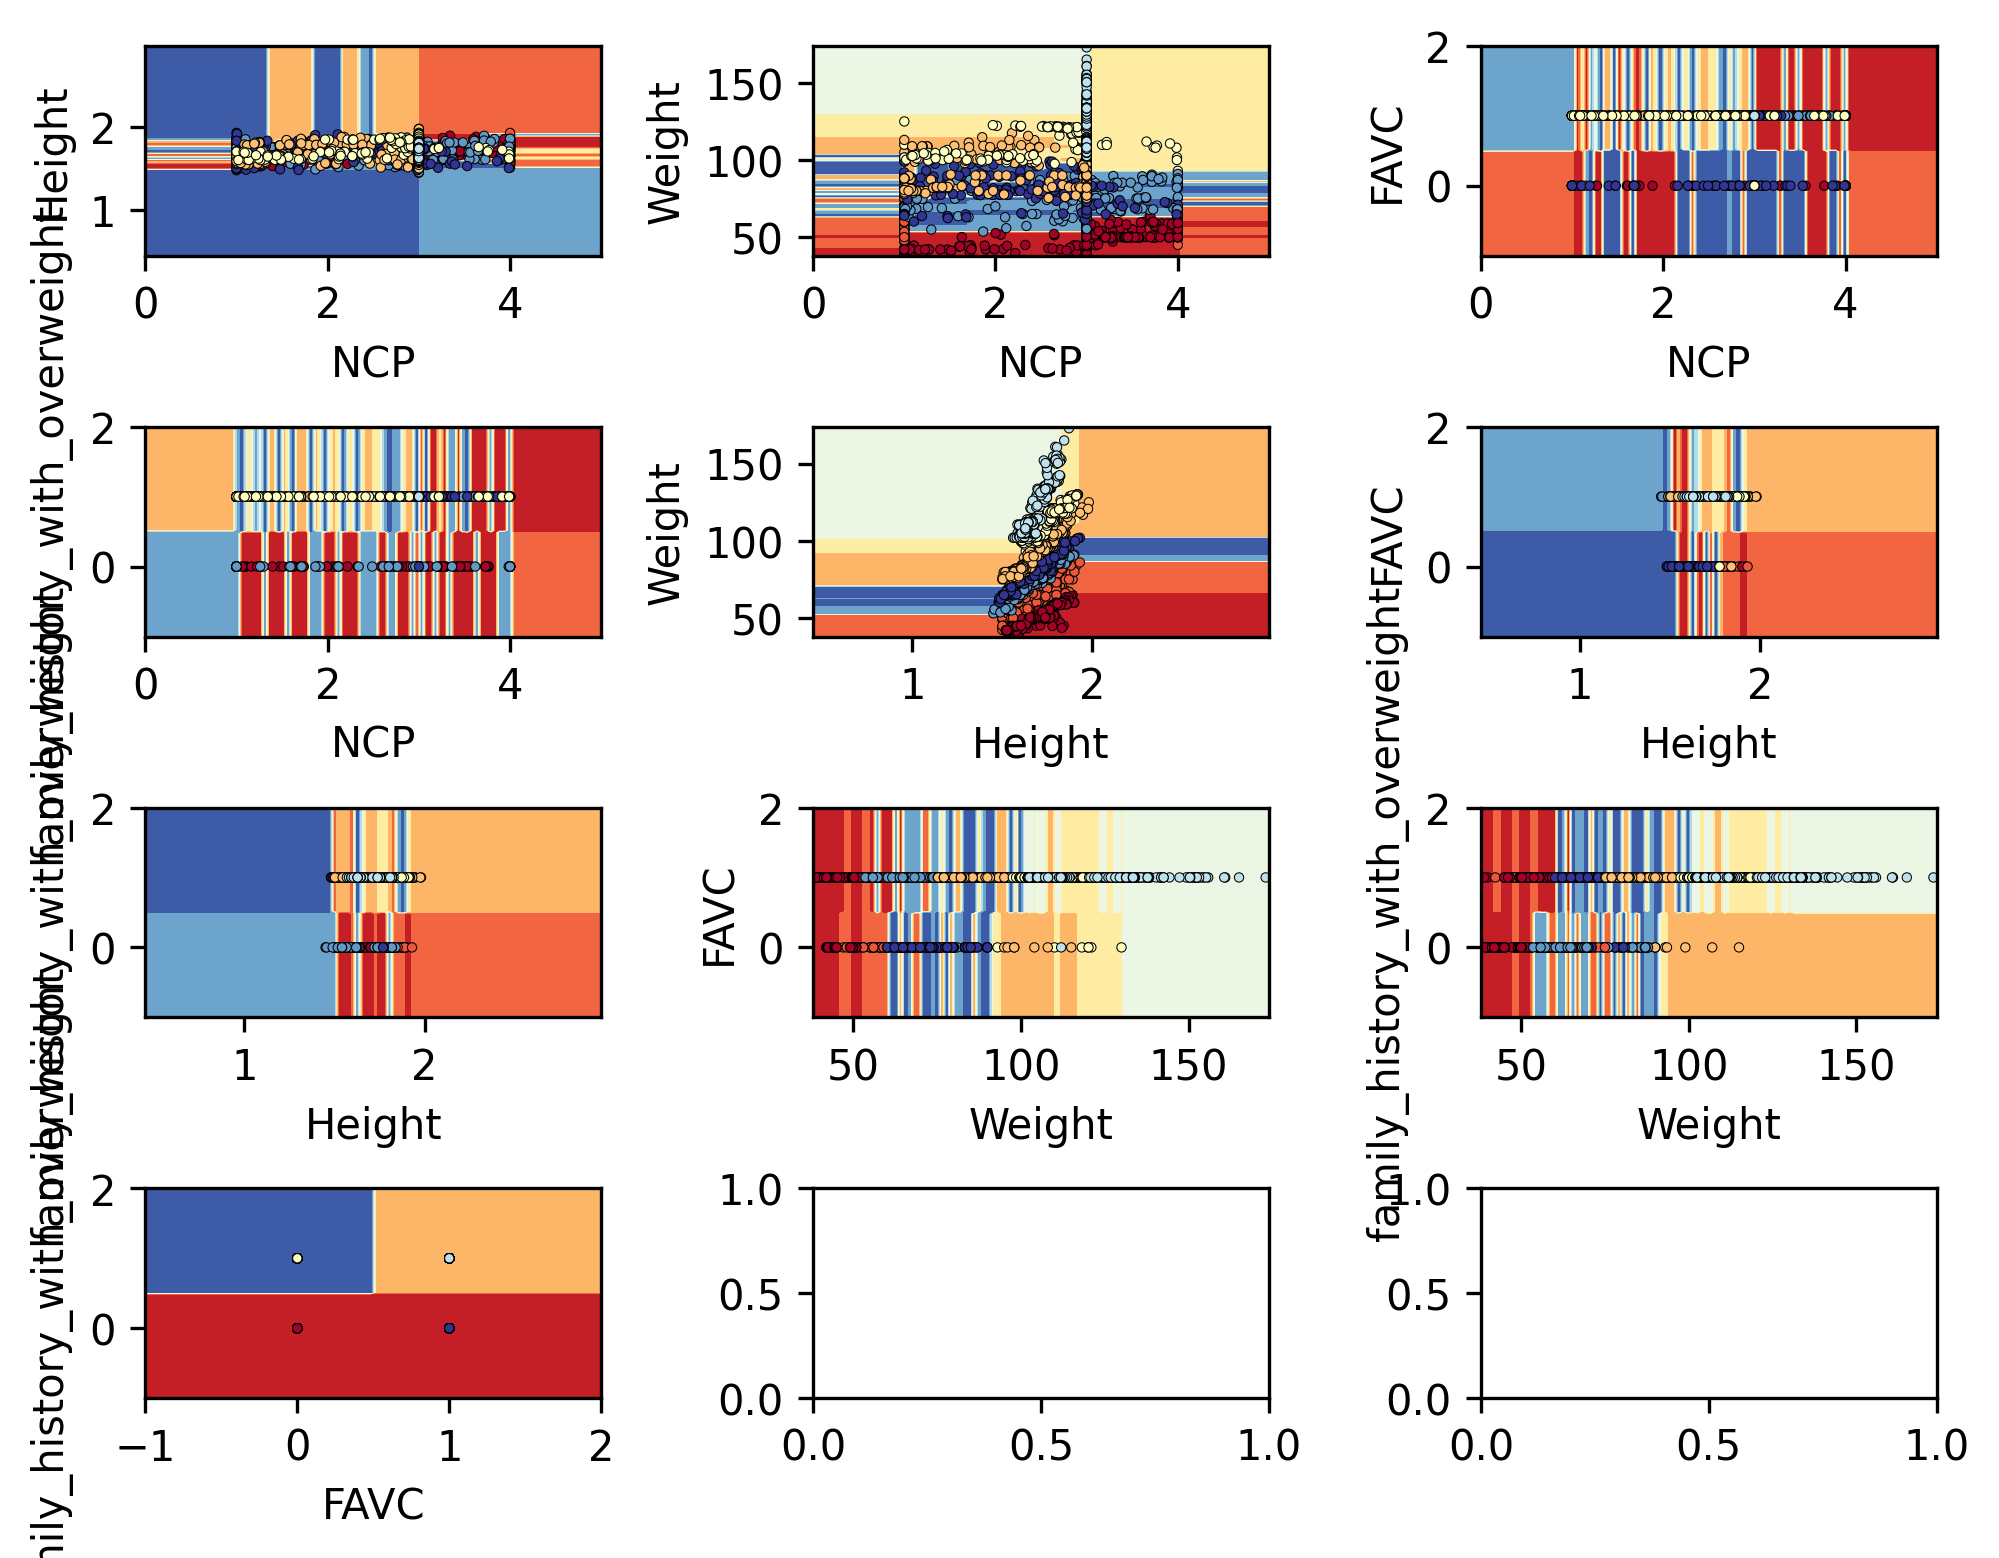

<Figure size 1920x1440 with 0 Axes>

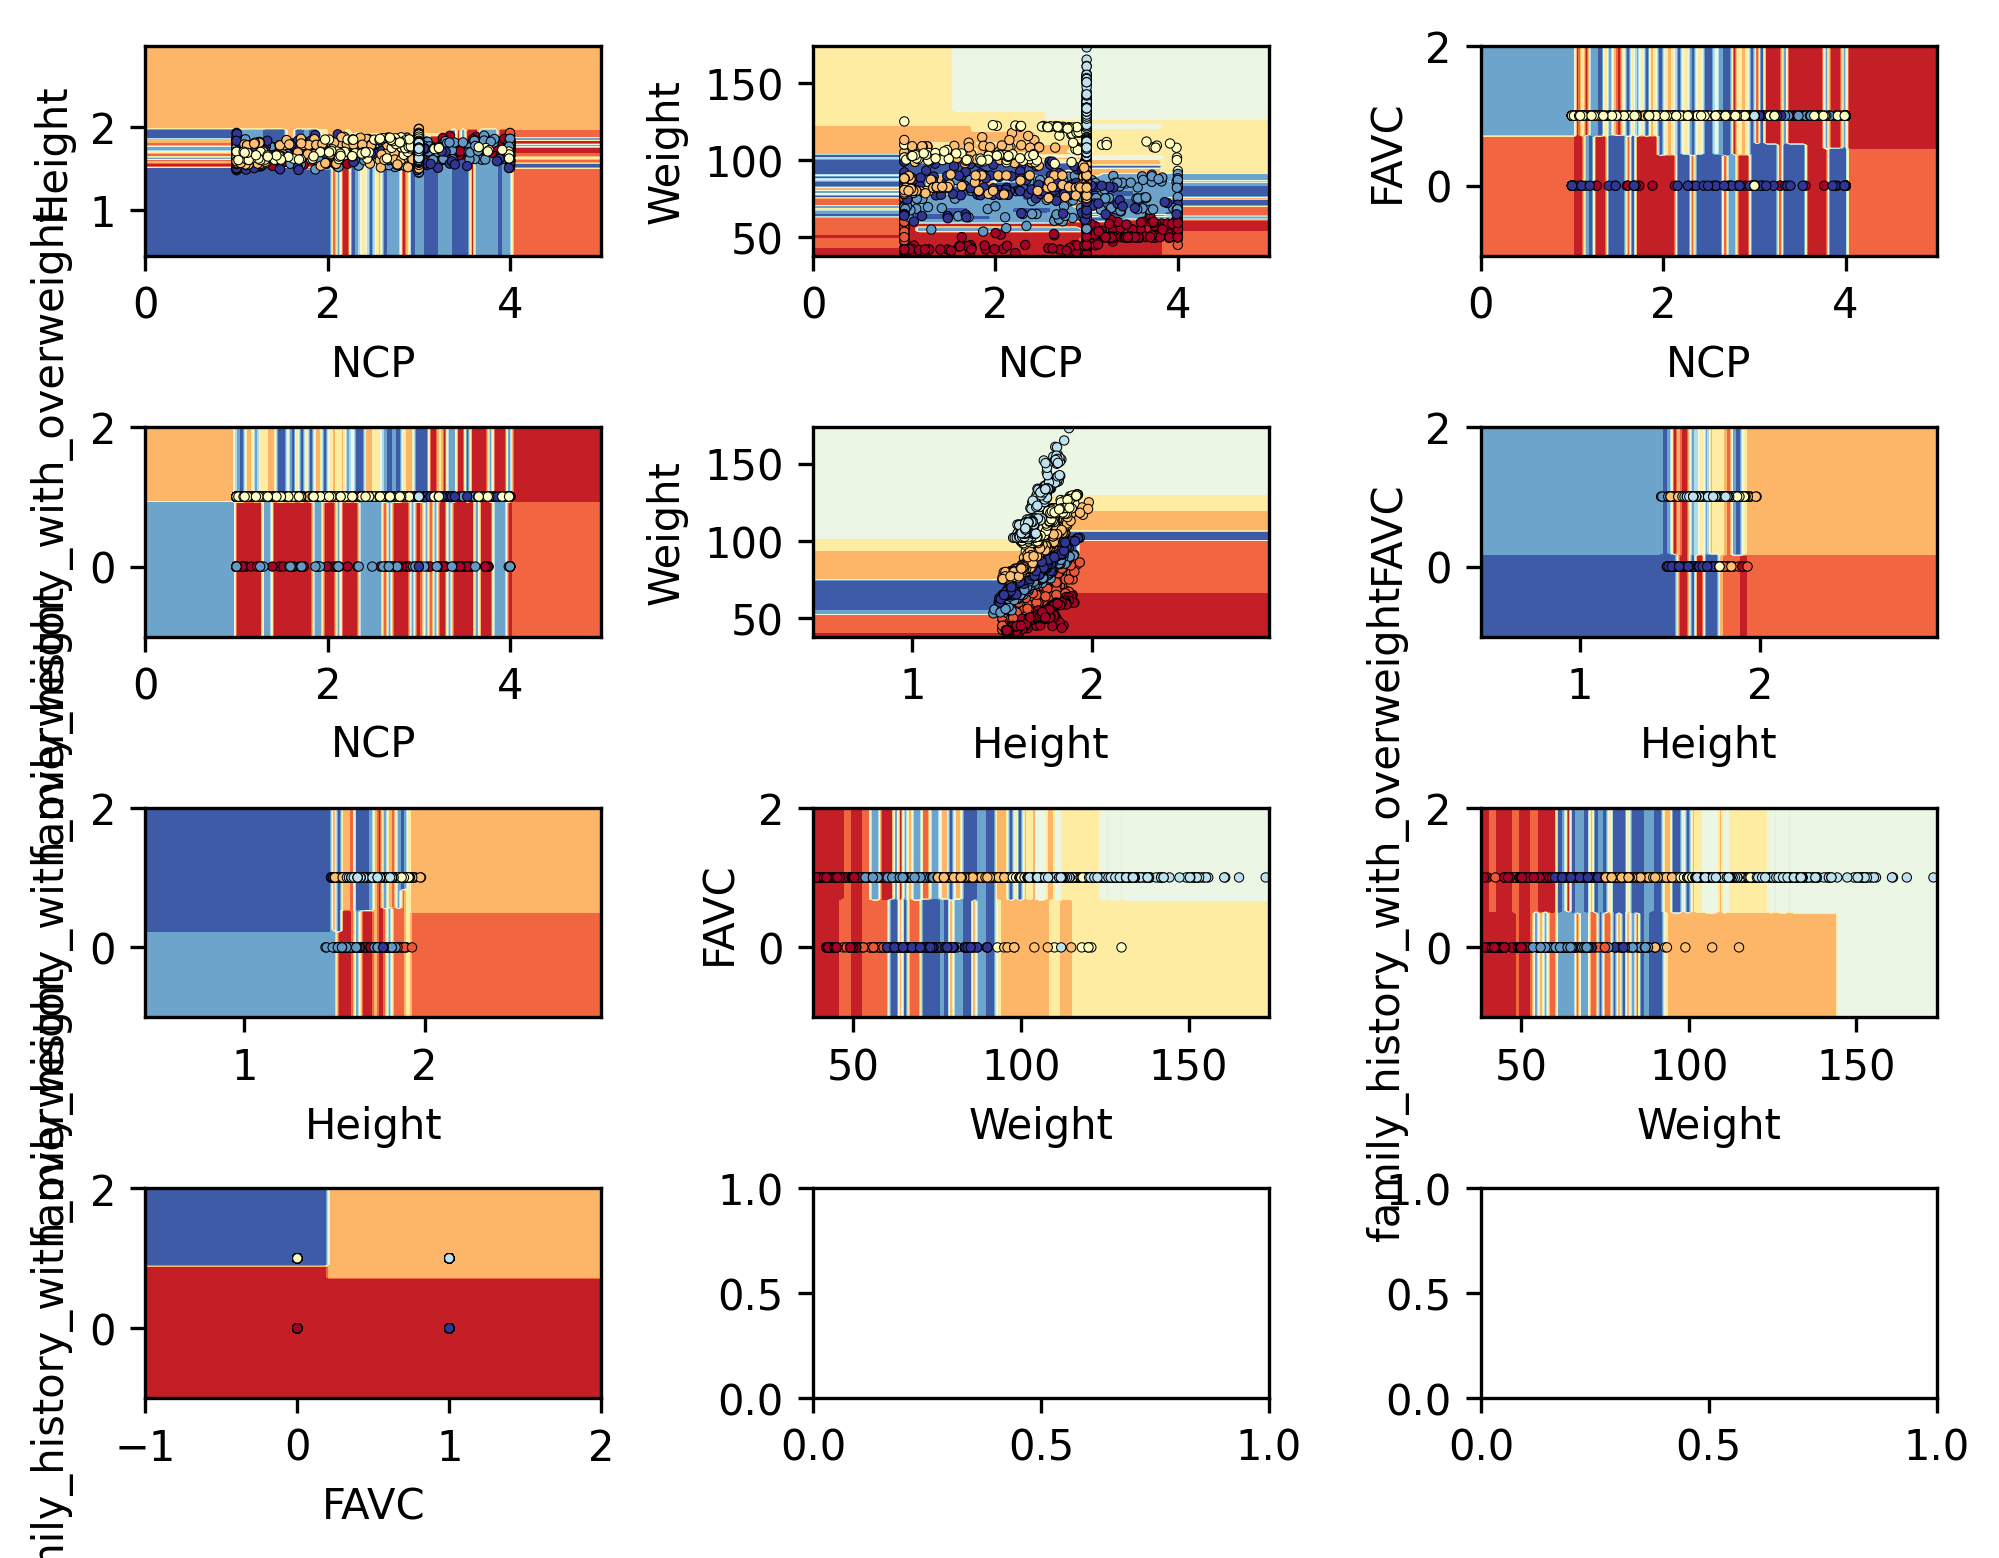

In [113]:
label_combinations = dataset_manager.make_label_combinations(SELECTED_FEATURES)
params_sets = [
    {"criterion": "gini", "splitter": "best"},
    {"criterion": "gini", "splitter": "random"},
]

for params_set in params_sets:
    plot_manager = PlotManager(cols=3, samples=len(label_combinations))
    
    for i, label_combination in enumerate(label_combinations):
        subplot = plot_manager[i]
        label_encoder = LabelEncoder()

        X = dataset_manager.labels_to_onehot(dataset_dataframe, label_combination)
        Y = dataset_dataframe[LABEL_VARIABLE]
        Y_encoded = label_encoder.fit_transform(Y)

        classifier = tree.ExtraTreeClassifier(criterion=params_set["criterion"], splitter=params_set["splitter"])
        classifier = classifier.fit(X, Y)


        DecisionBoundaryDisplay.from_estimator(
            classifier,
            X,
            cmap=plt.cm.RdYlBu,
            response_method="predict",
            ax=subplot,
            xlabel=label_combination[0],
            ylabel=label_combination[1],
        )

        subplot.scatter(
            X[X.columns[0]],
            X[X.columns[1]],
            c=Y_encoded,
            cmap=plt.cm.RdYlBu,
            linewidths=0.25,
            edgecolor="black",
            s=5,
        )

### 3. XGBoost

### 4. Naive Bayes

### 5. k-NN

### 6. Neural networks

### 7. SVM

### 8. Logistic regression